### Estimación de tiempos de atención para ordenes de trabajo: Suscripción y Emisión
Este modelo considera las ordenes de trabajo que entraron hasta 30 días antes de correr el programa y, que además su primer estatus fue "Pendiente" y el último estatus fue "Emitida" o "Rechazada. Se descartan los casos donde la orden permaneción en el mismo estado durante dicho periodo de tiempo.

In [2]:
# Importing all the necessary libraries
import numpy as np              # Numerical array manipulation
import matplotlib.pyplot as plt # Plotting capabilities
import pymc3 as pm              # Python Monte Carlo Markov Chain package
import functionES as es         # Customized functions for this project
import seaborn as sns           # Fancy plot visualizations
import arviz as az              # pymc objects visualization
import pandas as pd             # Dataframe manipulation
import BusinessHours as BH      # Extracting bussines hours
from datetime import datetime   # Datetime handling
sns.set()

#  Loading data
datos = es.importing_data('EmisionSuscripcion.sql')

# Filtering data to keep the request orders finished
emision = es.process_filter(datos[datos['IdTipoSolicitud'] == 5103])
suscripcion = es.process_filter(datos[datos['IdTipoSolicitud'] == 5104])

C:\Users\430008252\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\430008252\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [3]:
# Extracting the limits first and last update for each finished OT
[minEmision, maxEmision] = es.extract_lims(emision)
[minSuscripcion, maxSuscripcion] = es.extract_lims(suscripcion)

# Substracting the time in business hours: Emision
tiempoEmision = pd.Series([], dtype='int')
for i in range(0,len(emision)):
    hours = BH.BusinessHours(minEmision.iloc[i],
                             maxEmision.iloc[i]).gethours()
    if hours != 0:# Keeps values greater than zero
        tiempoEmision = tiempoEmision.append(pd.Series([hours]))

# Substracting the time in business hours: Suscripcion
tiempoSuscripcion = pd.Series([], dtype='int')
for i in range(0,len(suscripcion)):
    hours = BH.BusinessHours(minSuscripcion.iloc[i],
                             maxSuscripcion.iloc[i]).gethours()
    if hours != 0:# Keeps values greater than zero
        tiempoSuscripcion = tiempoSuscripcion.append(pd.Series([hours]))

#### Tiempos de atención en horas hábiles
En las siguientes figuras puede apreciarse los tiempos de atención y su distriución tanto para las OTs que nacen en emisión como para las de daños.

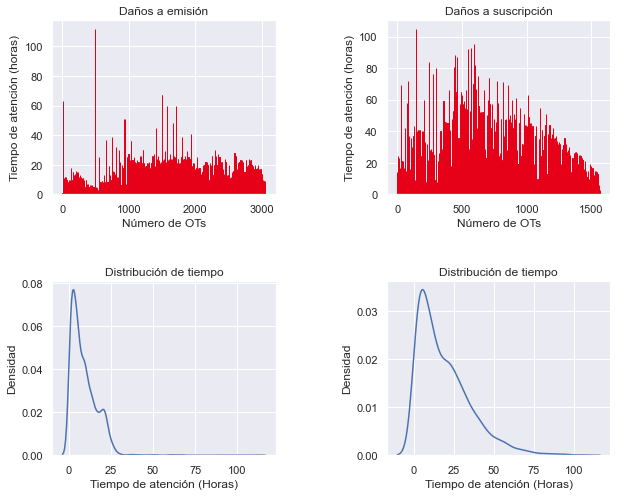

In [4]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows = 2, ncols = 2,
                                             figsize = (10,8))

ax1.bar(np.arange(len(tiempoEmision)),tiempoEmision, edgecolor = "#E60018")
ax1.yaxis.set_label_text("Tiempo de atención (horas)")
ax1.xaxis.set_label_text("Número de OTs")
ax1.set_title("Daños a emisión")

ax2.bar(np.arange(len(tiempoSuscripcion)),tiempoSuscripcion, edgecolor = "#E60018")
ax2.yaxis.set_label_text("Tiempo de atención (horas)")
ax2.xaxis.set_label_text("Número de OTs")
ax2.set_title("Daños a suscripción")

sns.kdeplot(tiempoEmision, ax = ax3)
ax3.yaxis.set_label_text("Densidad")
ax3.xaxis.set_label_text("Tiempo de atención (Horas)")
ax3.set_title("Distribución de tiempo")

sns.kdeplot(tiempoSuscripcion, ax = ax4)
ax4.yaxis.set_label_text("Densidad")
ax4.xaxis.set_label_text("Tiempo de atención (Horas)")
ax4.set_title("Distribución de tiempo")


fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

#### Resumen de datos
En la siguiente tabla, se muestra el resumen estadístico de los datos. Puede observarse que tanto en suscripción como en emisión, las medianas y los promedios no son tan diferentes; lo que indica que existen pocos datos atípicos conocidos como _outliers_.

In [5]:
pd.DataFrame(
    {
        'Emisión': tiempoEmision.describe(),
        'Suscripción': tiempoSuscripcion.describe()
    }
)

,Emisión,Suscripción
count,3057.000000,1570.000000
mean,9.078508,18.993631
std,7.679338,16.326769
min,1.000000,1.000000
25%,3.000000,6.000000
50%,7.000000,15.000000
75%,13.000000,28.000000
max,112.000000,105.000000


En las siguientes figuras, puede observarse un primer intervalo de alta densidad (HDI por sus siglas en inglés) que indica con un 90% de credibilidad que el 90% de las OTs entrantes se llevarán a cabo en hasta 20 horas para el caso de daños a emisión y en hasta 41 horas hábiles para el caso de suscripción.

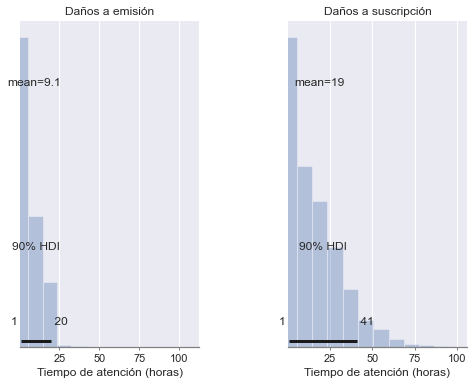

In [11]:
fig2, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (8,6))

pm.plot_posterior(tiempoEmision.to_numpy(), hdi_prob = 0.9, ax = ax1)
ax1.set_title("Daños a emisión")
ax1.xaxis.set_label_text("Tiempo de atención (horas)")

pm.plot_posterior(tiempoSuscripcion.to_numpy(), hdi_prob = 0.9, ax = ax2)
ax2.set_title("Daños a suscripción")
ax2.xaxis.set_label_text("Tiempo de atención (horas)")

fig2.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [7]:
[modelE, traceE] = es.MCMC(tiempoEmision)
[modelS, traceS] = es.MCMC(tiempoSuscripcion)

D:\Users\430008252\OneDrive - HDI Seguros\Documentos\EmisionSuscripcion\functionES.py:116: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune = 500, step = step, progressbar = True)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda_1]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 647 seconds.
The number of effective samples is smaller than 10% for some parameters.
D:\Users\430008252\OneDrive - HDI Seguros\Documentos\EmisionSuscripcion\functionES.py:116: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune = 500, step = step, progressbar = True)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda_1]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 435 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [8]:
with modelE:
    posterior_predictiveE= pm.fast_sample_posterior_predictive(traceE)
with modelS:
    posterior_predictiveS= pm.fast_sample_posterior_predictive(traceS)

### Predicciones
Las siguientes figuras muestran que los intervalos de alta densidad con credibilidad del 99% son de 2 a 17 horas; y de 9 a 30 horas para emisión y suscripción respectivamente, con un promedio cada uno de 9 y 19 horas.

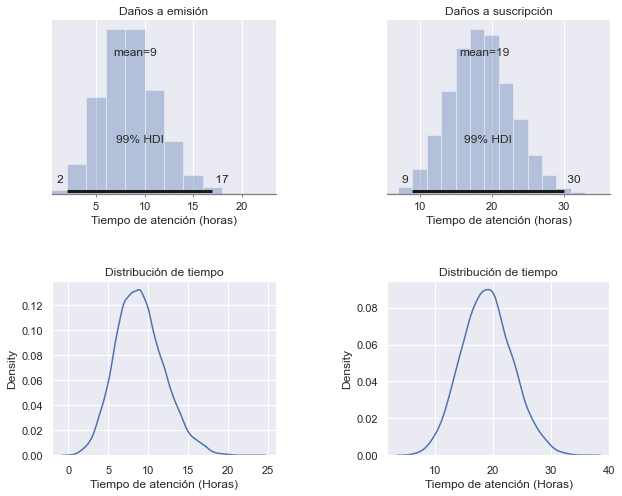

In [17]:
fig3, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows = 2, ncols = 2,
                                              figsize = (10,8))


az.plot_posterior(posterior_predictiveE["obs"][:,0], hdi_prob = 0.99, ax = ax1)
ax1.xaxis.set_label_text("Tiempo de atención (horas)")
ax1.set_title("Daños a emisión")

az.plot_posterior(posterior_predictiveS["obs"][:,0], hdi_prob = 0.99, ax = ax2)
ax2.xaxis.set_label_text("Tiempo de atención (horas)")
ax2.set_title("Daños a suscripción")

sns.kdeplot(posterior_predictiveE["obs"][:,0], ax = ax3)
ax3.xaxis.set_label_text("Tiempo de atención (Horas)")
ax3.set_title("Distribución de tiempo")

sns.kdeplot(posterior_predictiveS["obs"][:,0], ax = ax4)
ax4.xaxis.set_label_text("Tiempo de atención (Horas)")
ax4.set_title("Distribución de tiempo")


fig3.subplots_adjust(hspace = 0.5, wspace = 0.5)

La siguiente tabla muestra los valore mínimo y máximo con credibilidad del 90% que pueden tardar las OTs en emisión y suscripción, así como el primer, segundo y tercer cuartiles esperados. 

##### Nota:
Se utiliza el intervalo de alta densidad con credibilidad al 90% para eliminar cualquier _outlier_ que pudiera haber resultado en la simulación.

In [45]:
# Emisión
IQRx1_5E = 1.5*(np.quantile(posterior_predictiveE["obs"][:,0], 0.75)-np.quantile(posterior_predictiveE["obs"][:,0], 0.25))
prediccionE = pd.DataFrame(np.array([[np.quantile(posterior_predictiveE["obs"][:,0], 0.25)-IQRx1_5E
                          , np.quantile(posterior_predictiveE["obs"][:,0], 0.25)
                          , np.quantile(posterior_predictiveE["obs"][:,0], 0.50)
                          , np.quantile(posterior_predictiveE["obs"][:,0], 0.75)
                          , np.quantile(posterior_predictiveE["obs"][:,0], 0.75)+IQRx1_5E]])
                          , columns = ["Min_90", "Q1", "Q2", "Q3", "Max_90"]
                          , index = ["Emisión"])
prediccionE["FechaPrediccion"]= datetime.today()

# Suscripción
IQRx1_5S = 1.5*(np.quantile(posterior_predictiveS["obs"][:,0], 0.75)-np.quantile(posterior_predictiveS["obs"][:,0], 0.25))
prediccionS = pd.DataFrame(np.array([[np.quantile(posterior_predictiveS["obs"][:,0], 0.25)-IQRx1_5S
                          , np.quantile(posterior_predictiveS["obs"][:,0], 0.25)
                          , np.quantile(posterior_predictiveS["obs"][:,0], 0.50)
                          , np.quantile(posterior_predictiveS["obs"][:,0], 0.75)
                          , np.quantile(posterior_predictiveS["obs"][:,0], 0.75)+IQRx1_5S]])
                          , columns = ["Min_90", "Q1", "Q2", "Q3", "Max_90"]
                          , index = ["Suscripción"])
prediccionS["FechaPrediccion"]= datetime.today()

pd.concat([prediccionE, prediccionS])

,Min_90,Q1,Q2,Q3,Max_90,FechaPrediccion
Emisión,1.0,7.0,9.0,11.0,17.0,2021-05-18 17:18:13.004252
Suscripción,7.0,16.0,19.0,22.0,31.0,2021-05-18 17:18:13.008239
